In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid',context='notebook')

In [2]:
data = pd.read_csv('/work/archive/insurance.csv')
df = pd.DataFrame(data)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Analizando los datos

Se observará cómo se distribuyen los datos de la variable a predecir.

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

(1338, 7)


<AxesSubplot:>

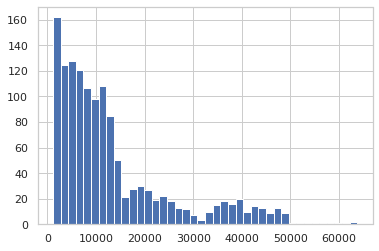

In [3]:
print(df.shape)

df.charges.hist(bins=40)

En este caso, al ser pocos datos (6 de 1338), eliminaremos estos datos atípicos. A modo didáctico producen más ruido en la predicción que se está intentando hacer en este ejercicio. 

Sin embargo es importante aclarar que **NO SE DEBEN ELIMINAR** datos atípicos sin antes conocer a alguien que conozca o sea experto en los datos para que pueda guiarnos mejor sobre ellos.

In [4]:
df[df.charges>50000]
df = df[df.charges<50000]

## viendo correlaciones entre los datos 

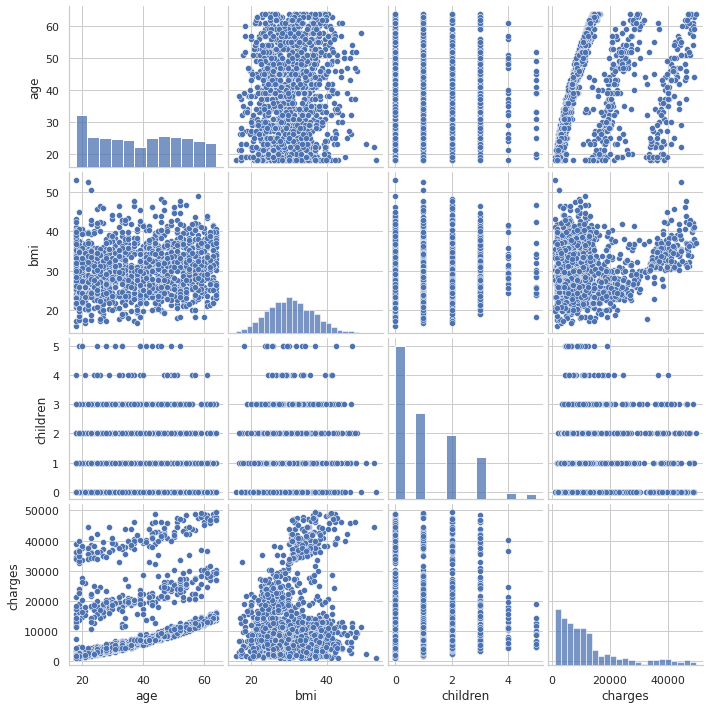

In [5]:
sns.pairplot(df, height=2.5)
plt.show()

<AxesSubplot:>

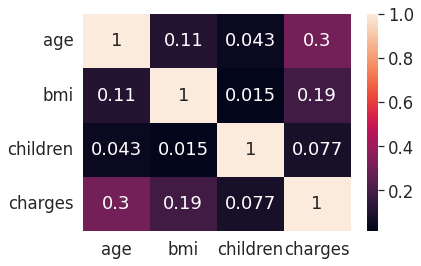

In [6]:
numeric_cols = ['age','bmi','children','charges']
cm = np.corrcoef(df[numeric_cols].values.T)
sns.set(font_scale=1.5)
sns.heatmap(cm,annot=True, yticklabels=numeric_cols, xticklabels=numeric_cols)

Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después.

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

## Utilizando las demás variables
Las demás variables son variables categoricas, sexo, fumador, región.

In [7]:
df = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True)
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


## Creando modelos 
Primero se usará un modelo con todas las variables.

In [8]:
X_cols = list(set(df.columns)-set(['charges']))
Y_cols = ['charges']

x =df[X_cols].values
y =df[Y_cols].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x,y)
sc_x = StandardScaler().fit(x)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)

y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

In [10]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred.shape

(333, 1)

## Funciones de métricas
El siguiente punto es calcular las métricas del modelo.

In [11]:
import sklearn.metrics as metrics
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2 ", r2.round(4))
print("mse: ", mse.round(4))

r2  0.7432
mse:  0.2398


resumen general de los resultados.

In [12]:
!pip install regressors

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [13]:
from regressors import stats
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

In [14]:
y_test = y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========
Residuals:
  Min      1Q  Median     3Q    Max
-1.82 -0.0646  0.1056 0.2632 0.9838


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept        0.007050    0.027007   0.2610  0.794219
smoker_yes        0.806528    0.027241  29.6073  0.000000
children          0.037209    0.027915   1.3329  0.183466
region_southeast -0.051896    0.033056  -1.5700  0.117377
bmi               0.166290    0.030359   5.4775  0.000000
region_northwest -0.018704    0.030679  -0.6097  0.542507
age               0.300786    0.027819  10.8122  0.000000
region_southwest -0.028946    0.031734  -0.9121  0.362355
sex_male         -0.017690    0.027346  -0.6469  0.518148
---
R-squared:  0.74324,    Adjusted R-squared:  0.73690
F-statistic: 117.23 on 8 features


función que calcula los residuales. Es importante notar que es una simple resta entre los valores reales y los predichos.

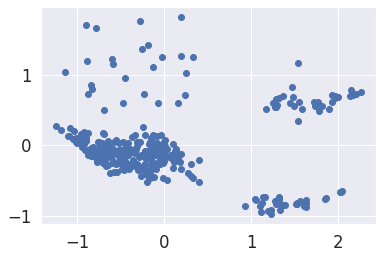

In [15]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.show()

## Segundo modelo
Estos resultados de arriba son buenos, pero se pueden mejorar. Intentaremos hacer algunas transformaciones sobre las variables que pueden ser de utilidad.

In [16]:
df_second = df.copy()
df_second['age2'] = df_second.age**2
df_second['sobrepeso'] = (df_second.bmi >= 30).astype(int)
df_second['sobrepeso*fumador'] = df_second.sobrepeso * df_second.smoker_yes

Analizando el segundo modelo

In [17]:
X_cols = ['sobrepeso*fumador', 'smoker_yes', 'age2', 'children']
y_col = ['charges']

X = df_second[X_cols].values
y = df_second[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression(fit_intercept=False)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [18]:
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2 ", r2.round(4))
print("mse: ", mse.round(4))

r2  0.8951
mse:  0.1183


In [19]:
model.coef_ = model.coef_.reshape(-1)

In [20]:
y_test = y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========
Residuals:
    Min     1Q  Median     3Q    Max
-1.8319 0.0743  0.1182 0.1556 0.3984


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.000000    0.018910   0.0000  1.000000
sobrepeso*fumador  0.495226    0.022007  22.5027  0.000000
smoker_yes         0.455046    0.021934  20.7458  0.000000
age2               0.325401    0.019203  16.9454  0.000000
children           0.064065    0.019290   3.3212  0.000996
---
R-squared:  0.89513,    Adjusted R-squared:  0.89385
F-statistic: 699.94 on 4 features


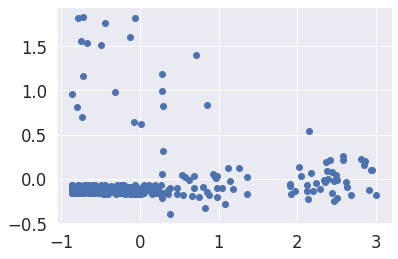

In [21]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=05e34d36-abd8-45b8-a0cd-2fb2c9650688' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>